In [ ]:
from local.test import *
from local.data.all import *
from local.notebook.showdoc import show_doc

from local.vision.core import *
from local.vision.augment import *

# Data block examples

> Examples for computer vision, NLP, and tabular

## Image classification

### MNIST

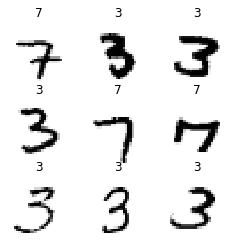

In [ ]:
mnist = DataBlock(types=(PILImageBW, Category), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dbunch = mnist.databunch(untar_data(URLs.MNIST_TINY))
dbunch.show_batch(max_n=9, figsize=(4,4))

### Pets

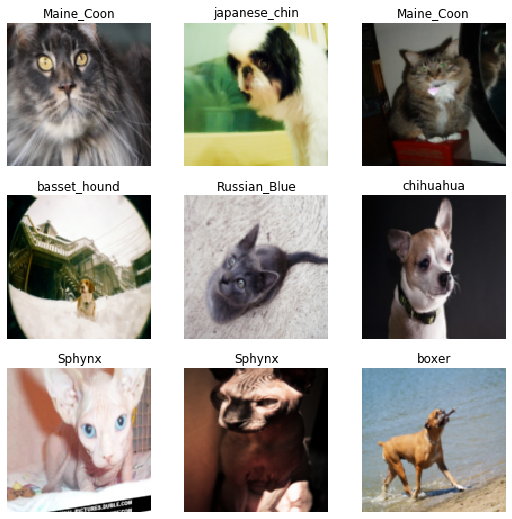

In [ ]:
pets = DataBlock(types=(PILImage, Category), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'))

dbunch = pets.databunch(untar_data(URLs.PETS)/"images", item_tfms=Resize(128),
                        batch_tfms=aug_transforms())
dbunch.show_batch(max_n=9)

### Multi-label - Planet

In [ ]:
MultiCategory.default_type_tfms = OneHotEncode

In [ ]:
planet_source = untar_data(URLs.PLANET_TINY)
df = pd.read_csv(planet_source/"labels.csv")

In [ ]:
planet = DataBlock(types=(PILImage, MultiCategory),
                   get_x=lambda x:planet_source/"train"/f'{x[0]}.jpg',
                   splitter=RandomSplitter(),
                   get_y=lambda x:x[1].split(' '))

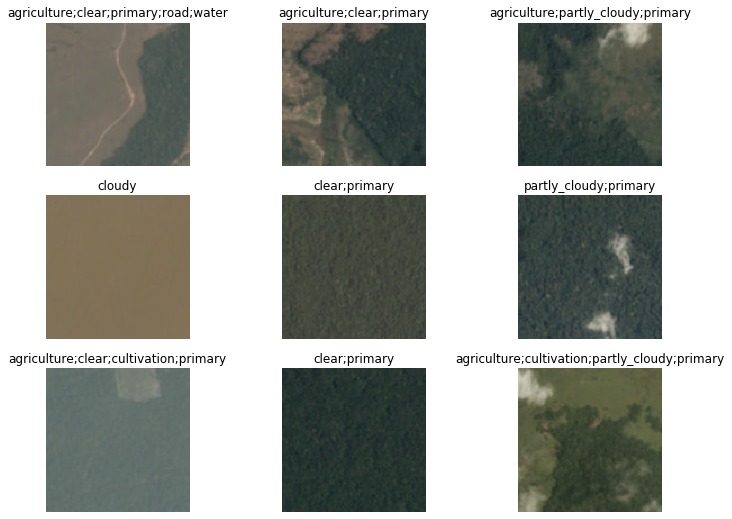

In [ ]:
dbunch = planet.databunch(df.values,
         batch_tfms=aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))
dbunch.show_batch(max_n=9, figsize=(12,9))

In [ ]:
def _planet_items(x): return (
    f'{planet_source}/train/'+x.image_name+'.jpg', x.tags.str.split())

planet = DataBlock(types=(PILImage,MultiCategory),
                   get_items = _planet_items,
                   splitter = RandomSplitter())

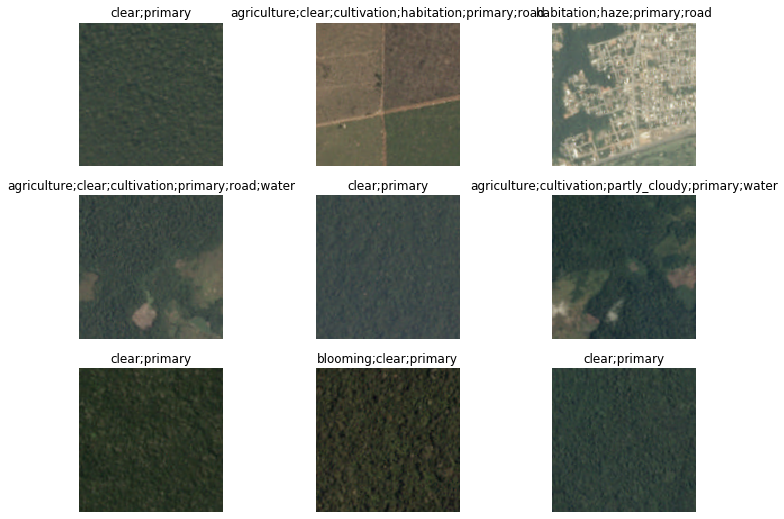

In [ ]:
dbunch = planet.databunch(df, batch_tfms=aug_transforms(
    flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))
dbunch.show_batch(max_n=9, figsize=(12,9))

In [ ]:
class PlanetDataBlock(DataBlock):
    types = PILImage,MultiCategory
    splitter = staticmethod(RandomSplitter())
    def get_items(self, x): return (
        f'{planet_source}/train/' + x.image_name + '.jpg', x.tags.str.split())

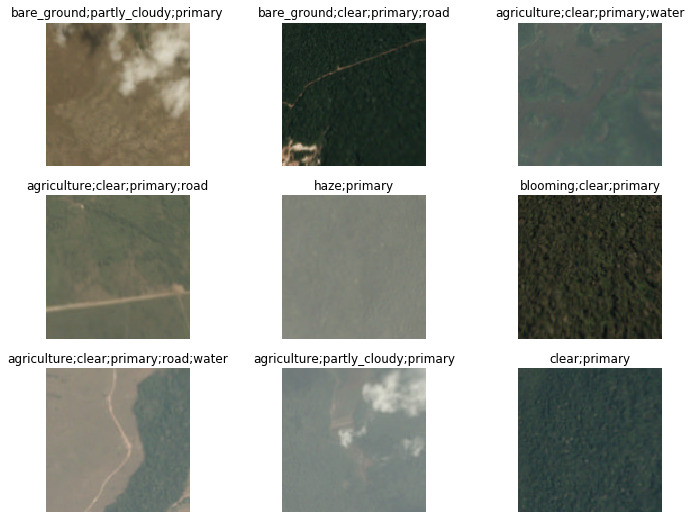

In [ ]:
planet = PlanetDataBlock()
dbunch = planet.databunch(df, batch_tfms=aug_transforms(flip_vert=True))
dbunch.show_batch(max_n=9, figsize=(12,9))

In [ ]:
planet = DataBlock(types=(PILImage,MultiCategory),
                   get_x = lambda o:f'{planet_source}/train/'+o.image_name+'.jpg',
                   get_y = lambda o:o.tags.split(),
                   splitter = RandomSplitter())

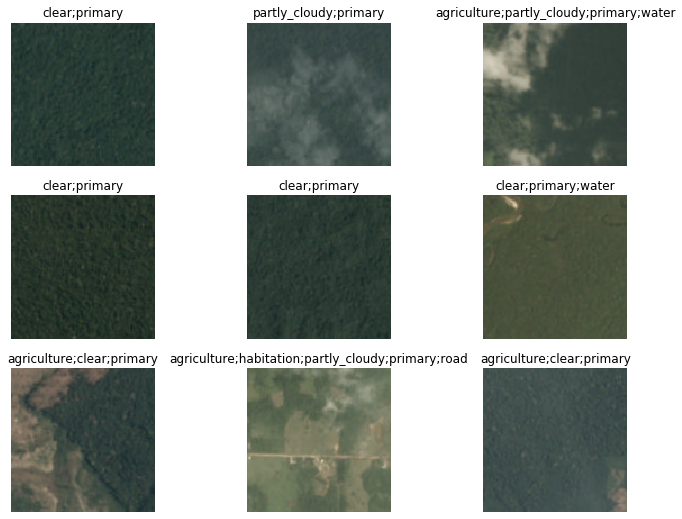

In [ ]:
dbunch = planet.databunch(df, batch_tfms=aug_transforms(
    flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))
dbunch.show_batch(max_n=9, figsize=(12,9))

## Image localization

### Segmentation

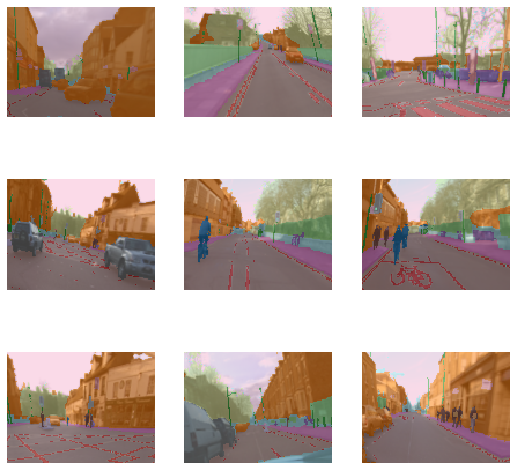

In [ ]:
camvid = DataBlock(types=(PILImage, PILMask),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=lambda o: untar_data(URLs.CAMVID_TINY)/'labels'/f'{o.stem}_P{o.suffix}')

dbunch = camvid.databunch(untar_data(URLs.CAMVID_TINY)/"images",
                          batch_tfms=aug_transforms())
dbunch.show_batch(max_n=9, vmin=1, vmax=30)

### Points

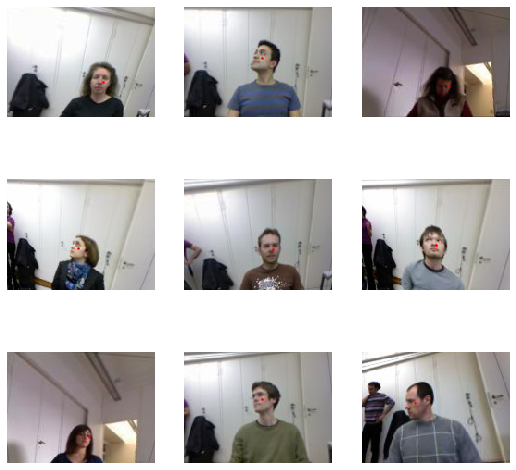

In [ ]:
biwi_source = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = (biwi_source/'centers.pkl').load()

biwi = DataBlock(types=(PILImage, TensorPoint),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=lambda o:fn2ctr[o.name].flip(0))

dbunch = biwi.databunch(biwi_source, batch_tfms=aug_transforms())
dbunch.show_batch(max_n=9)

### Bounding boxes

In [ ]:
coco_source = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco_source/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

In [ ]:
coco = DataBlock(types=(PILImage, TensorBBox, NotEncodedMultiCategory),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 getters=[noop, lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]], n_inp=1)

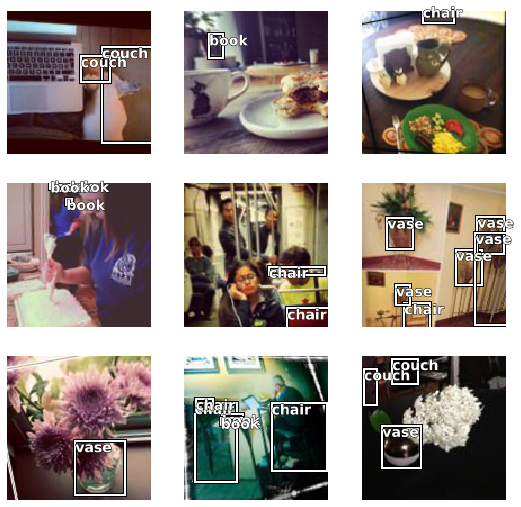

In [ ]:
dbunch = coco.databunch(coco_source, item_tfms=Resize(128),
                        batch_tfms=aug_transforms())
dbunch.show_batch(max_n=9)

### Language model

In [ ]:
from local.text.all import *

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(path/'texts.csv')
df_tok,count = tokenize_df(df, 'text')

In [ ]:
imdb_lm = DataBlock(types=(LMText(make_vocab(count)),),
                    get_x=attrgetter('text'),
                    splitter=RandomSplitter())

In [ ]:
dbunch = imdb_lm.databunch(df_tok, bs=64, seq_len=72)

In [ ]:
dbunch.show_batch(max_n=6)

,text
0,"xxbos xxmaj absolutely fantastic trash … xxunk one has it all : nudity , good fight scenes , gore , action , explosions etc . xxmaj it also stars the wonderful xxmaj xxunk xxmaj xxunk as xxmaj ingrid - not xxmaj olga as the other reviewer pointed out - although xxmaj olga turns into xxmaj ingrid later on in the film ( you 'll have to watch it to see what i"
1,"will agree with me . xxmaj this movie , shows xxmaj serbian side , and only xxmaj serbian side . xxmaj no xxmaj serbian crimes were represented . xxmaj luckily , everyone can see that this movie was made by xxmaj xxunk , so there is no xxunk . xxmaj all ' ' professionals ' ' who were xxunk are not professionals at all . xxmaj some guy only read a book"
2,"for the reason why many movie tie - in pilots never air . xxbos xxmaj working - class romantic drama from director xxmaj martin xxmaj xxunk is as unbelievable as they come , yet there are moments of pleasure due mostly to the charisma of stars xxmaj jane xxmaj fonda and xxmaj robert xxmaj de xxmaj niro ( both terrific ) . xxmaj she 's a widow who ca n't move on"
3,"bit boring , but xxmaj i 'm glad i stuck with it . xxmaj basically xxmaj may ( anne xxmaj reid ) is a single mother of xxmaj helen ( anna wilson - jones ) who hardly sees anyone and has not had a boyfriend in years . xxmaj her daughter says that she might want to get married to her new boyfriend , xxmaj darren ( daniel xxmaj craig , of"
4,"it was an interesting character study and very well shot ( on digital video , unusual for a period piece ) . xxmaj the acting was excellent all round , particularly xxmaj tim xxunk and xxmaj brian xxmaj cox although the actor who portrayed xxup xxunk , whose name i can not remember impressed me no end . xxmaj an excellent character study which has about the same amount of twists as"
5,"that seemed to have upset xxmaj beth even more then her boyfriend being murdered at the beginning of the movie ! xxbos xxmaj william xxmaj hurt may not be an xxmaj american xxunk idol anymore , but he still has pretty good taste in xxmaj b - movie projects . xxmaj here , he plays a xxunk in xxunk waste clean - ups with a tragic past xxunk down a xxunk loser"


### Text classification TODO

In [ ]:
imdb_clas = DataBlock(types=(Text(make_vocab(count)), Category),
                      get_x=attrgetter('text'),
                      get_y=attrgetter('label'),
                      splitter=RandomSplitter())

In [ ]:
dbunch = imdb_clas.databunch(df_tok, bs=64, seq_len=72)

In [ ]:
dbunch.show_batch(max_n=2)

### Tabular data TODO

In [ ]:
from local.tabular.core import *

In [ ]:
adult_source = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult_source/'adult.csv')

In [ ]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter()(range_of(df))

In [ ]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names="salary", splits=splits)

In [ ]:
dbch = to.databunch()
dbch.show_batch()

,age,fnlwgt,education-num,workclass,education,marital-status,occupation,relationship,race,age_na,fnlwgt_na,education-num_na,salary
0,75.000000,146576.000464,13.0,Self-emp-not-inc,Bachelors,Widowed,Prof-specialty,Unmarried,White,False,False,False,>=50k
1,22.000000,445758.008457,3.0,Private,5th-6th,Never-married,Handlers-cleaners,Not-in-family,White,False,False,False,<50k
2,44.000000,222634.998594,3.0,Private,5th-6th,Married-civ-spouse,Machine-op-inspct,Husband,Black,False,False,False,<50k
3,28.000000,96019.998720,13.0,Private,Bachelors,Married-civ-spouse,Exec-managerial,Wife,White,False,False,False,>=50k
4,65.000000,93317.998748,10.0,Private,Some-college,Married-civ-spouse,Exec-managerial,Wife,White,False,False,False,<50k
5,17.000001,143791.000390,6.0,Private,10th,Never-married,Other-service,Own-child,Black,False,False,False,<50k
6,18.000000,118847.001768,9.0,?,HS-grad,Never-married,?,Own-child,White,False,False,False,<50k
7,36.000000,250807.001552,7.0,Private,11th,Never-married,Craft-repair,Not-in-family,Black,False,False,False,<50k
8,51.000000,208302.000227,12.0,Self-emp-inc,Assoc-acdm,Married-civ-spouse,Sales,Husband,White,False,False,False,>=50k
9,32.000000,198182.999778,10.0,Private,Some-college,Divorced,Exec-managerial,Not-in-family,White,False,False,False,<50k
